# Introduction to Natural Language Processing: Assignment 3

In this exercise we'll practice training RNN & LSTM models as well as fine-tuning LLMs to predict one or more labels for a given text using Hugging Face and PyTorch.

- You can use any Python package you need.
- Please comment your code
- Submissions are due Tuesdays at 23:59 **only** on eCampus: **Assignmnets >> Student Submissions >> Assignment 3 (Deadline: 10.12.2024, at 23:59)**

- Name the file aproppriately: "Assignment_3_\<Your_Name\>.ipynb" and submit only the Jupyter Notebook file.

### Task 1 (15 points)

In this task you will implement text generation in torch with a multi-layer RNN and multi-layer LSTM.

In [1]:
import torch
from torch import Tensor
from typing import List
from pandas import read_csv
import string

class Dataset(torch.utils.data.Dataset):
    def __init__(self, sequence_length):
        self.sequence_length = sequence_length
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self) -> List[str]:
        """Returns a list of all words in the dataset.
        Make sure to strip punctuation and lowercase the words"""
        try:
            df = read_csv('reddit-cleanjokes.csv')  # Ensure file is present in the working directory
        except FileNotFoundError:
            raise FileNotFoundError("The file 'reddit-cleanjokes.csv' was not found. Please check the path.")

        text = ' '.join(df['Joke'])
        text = text.translate(str.maketrans('', '', string.punctuation)).lower()
        words = text.split()
        return words

    def get_uniq_words(self) -> List[str]:
        """Returns a list, containing each unique word in the dataset once"""
        return list(set(self.words))

    def __len__(self):
        """Returns the number of self.sequence_length length word spans in the dataset"""
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index) -> (Tensor, Tensor):
        """Returns a tuple of two torch.Tensors:
        an input sequence for the RNN/LSTM model and a target sequence.
        The tensors should be 1D and have length equal to self.sequence_length.
        Remember that the target should be shifted with respect to the input."""
        input_seq = self.words_indexes[index:index + self.sequence_length]
        target_seq = self.words_indexes[index + 1:index + 1 + self.sequence_length]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target_seq, dtype=torch.long)


In [2]:
dataset = Dataset(sequence_length=4)
words = dataset.load_words()
print(words)

['what', 'did', 'the', 'bartender', 'say', 'to', 'the', 'jumper', 'cables', 'you', 'better', 'not', 'try', 'to', 'start', 'anything', 'dont', 'you', 'hate', 'jokes', 'about', 'german', 'sausage', 'theyre', 'the', 'wurst', 'two', 'artists', 'had', 'an', 'art', 'contest', 'it', 'ended', 'in', 'a', 'draw', 'why', 'did', 'the', 'chicken', 'cross', 'the', 'playground', 'to', 'get', 'to', 'the', 'other', 'slide', 'what', 'gun', 'do', 'you', 'use', 'to', 'hunt', 'a', 'moose', 'a', 'moosecut', 'if', 'life', 'gives', 'you', 'melons', 'you', 'might', 'have', 'dyslexia', 'broken', 'pencils', 'are', 'pointless', 'what', 'did', 'one', 'snowman', 'say', 'to', 'the', 'other', 'snowman', 'do', 'you', 'smell', 'carrots', 'how', 'many', 'hipsters', 'does', 'it', 'take', 'to', 'change', 'a', 'lightbulb', 'its', 'a', 'really', 'obscure', 'number', 'youve', 'probably', 'never', 'heard', 'of', 'it', 'where', 'do', 'sick', 'boats', 'go', 'the', 'dock', 'i', 'like', 'my', 'slaves', 'like', 'i', 'like', 'my', 

b) Now, complete the implementation of the RNN model.

You'll need to use all the model components defined in `__init__`: [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html), [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), and the [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) output layer. These are all subclasses of [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

Torch Modules are objects that hold the layer's weights and biases (called parameters, accessed by `model.parameters()`) and keep track of a bunch of metadata, like what device the weights are on or what precision they're stored at. Each Module can have parts that are themselves Modules. The easiest way to combine Modules is with [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

Every Module must have a `forward` method. This defines what the Module does with its input and returns as output. You can access `forward` simply by calling the Module, for example `output = self.rnn(input)`. This is the preferred way to write it.

Hint: unlike the one we saw in the tutorial, this RNN has multiple layers. Think about what this means for the shape of the hidden state. You might not want to use Sequential as RNN has multiple inputs and outputs.

In [3]:
from torch import nn, Tensor
class RNNModel(nn.Module):
    def __init__(self, dataset):
        super(RNNModel, self).__init__()
        self.hidden_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.rnn = nn.RNN(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,  # Ensures input/output tensors are (batch, seq, feature)
            dropout=0.2,
        )
        self.fc = nn.Linear(self.hidden_size, n_vocab)

    def init_state(self, batch_size: int) -> Tensor:
        """Returns the initial state hidden state (all zeros), with the correct shape."""
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(next(self.parameters()).device)

    def forward(self, inputs: Tensor, prev_hidden_state: Tensor) -> (Tensor, Tensor):
        """Compute the logits and next_hidden_state."""
        # 1. Embed the input tensor
        embedded = self.embedding(inputs)  # Shape: (batch, seq_len, embedding_dim)

        # 2. Pass through the RNN
        rnn_out, next_hidden_state = self.rnn(embedded, prev_hidden_state)
        # rnn_out shape: (batch, seq_len, hidden_size)

        # 3. Apply the fully connected layer to get logits
        logits = self.fc(rnn_out)  # Shape: (batch, seq_len, n_vocab)

        return logits, next_hidden_state

In [4]:
model = RNNModel(dataset)

c) Write a function that counts the total number of parameters and total number of trainable parameters of a model.

Refer to the [torch documentation](https://pytorch.org/docs/stable/index.html).

In [5]:
def count_params(model: nn.Module) -> (int, int):
    # YOUR CODE HERE
    n_params = 0
    n_trainable_params = 0

    # Iterate over all model parameters
    for param in model.parameters():
        n_params += param.numel()  # Add the total number of elements in this parameter tensor
        if param.requires_grad:
            n_trainable_params += param.numel()  # Add the trainable parameters

    return n_params, n_trainable_params

d) Complete the training loop and train the model for 10 epochs. Store the training loss in a list. You will probably want to have an inner loop that loops over batches.

Hint: refer to the documentation of the `DataLoader`, `CrossEntropyLoss` and `Optimizer` classes. You might also need to use the `detach()` and `item()` methods to work with the loss tensor.

In [6]:
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
from typing import List
def train_rnn(dataset, model, sequence_length, batch_size, max_epochs) -> List[float]:
    model.train()  # Set the model to training mode

    # Create DataLoader to handle batching
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # List to store the loss at each epoch
    loss_list = []

    # Loop through epochs
    for epoch in range(max_epochs):
        epoch_loss = 0.0  # Initialize loss for this epoch
        for inputs, targets in dataloader:
            # Ensure that the batch_size and input dimensions match
            batch_size = inputs.size(0)

            # Initialize the hidden state
            hidden_state = model.init_state(batch_size)

            # Zero the gradients from the previous step
            optimizer.zero_grad()

            # Forward pass
            logits, next_hidden_state = model(inputs, hidden_state)

            # Compute the loss
            # CrossEntropyLoss expects the shape (batch_size, num_classes), so we reshape the logits and targets
            logits = logits.view(-1, logits.size(-1))  # Flatten the logits to (batch_size * seq_len, n_vocab)
            targets = targets.view(-1)  # Flatten the targets to (batch_size * seq_len)

            loss = criterion(logits, targets)

            # Backpropagate the loss
            loss.backward()

            # Update the model parameters
            optimizer.step()

            # Accumulate the loss for this batch
            epoch_loss += loss.item()

        # Store the average loss for this epoch
        avg_epoch_loss = epoch_loss / len(dataloader)
        loss_list.append(avg_epoch_loss)

        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {avg_epoch_loss:.4f}")

    return loss_list

In [7]:
#!pip install datasets
train_loss_rnn = train_rnn(dataset, model, 4, 256, 10)

Epoch 1/10, Loss: 6.9026
Epoch 2/10, Loss: 6.1399
Epoch 3/10, Loss: 5.7392
Epoch 4/10, Loss: 5.4085
Epoch 5/10, Loss: 5.1247
Epoch 6/10, Loss: 4.8690
Epoch 7/10, Loss: 4.6553
Epoch 8/10, Loss: 4.4570
Epoch 9/10, Loss: 4.2671
Epoch 10/10, Loss: 4.0956


e) Complete the function to generate output from the model using 1. argmax (greedy) decoding 2. softmax decoding. Generate some sample outputs with each and discuss briefly.

Hint: torch already has a builtin function for getting the softmax of a tensor, which you may use.

In [8]:
import torch
import torch.nn.functional as F
from typing import List

def predict_rnn_argmax(dataset: Dataset, model: nn.Module, text: str, next_words=100) -> List[str]:
    model.eval()

    # Convert input text to a list of word indices
    words = text.split()
    input_seq = [dataset.word_to_index[word] for word in words]

    # Convert the input sequence to a tensor and add an extra dimension for batch size
    input_tensor = torch.tensor(input_seq).unsqueeze(0).long()

    # Initialize hidden state
    hidden_state = model.init_state(batch_size=1)

    generated_words = words.copy()  # List to store the generated words

    for _ in range(next_words):
        # Forward pass: Get the logits from the model
        logits, hidden_state = model(input_tensor, hidden_state)

        # Get the logits of the last word in the sequence
        logits = logits[:, -1, :]  # Shape: (batch_size, n_vocab)

        # Use argmax to select the word with the highest probability
        predicted_idx = torch.argmax(logits, dim=-1).item()

        # Convert the index to a word
        predicted_word = dataset.index_to_word[predicted_idx]

        # Append the predicted word to the list of generated words
        generated_words.append(predicted_word)

        # Update the input sequence for the next step
        input_tensor = torch.tensor([predicted_idx]).unsqueeze(0).long()

    return generated_words
def predict_rnn_softmax(dataset: Dataset, model: nn.Module, text: str, next_words=100) -> List[str]:
    model.eval()  # Set the model to evaluation mode

    # Convert input text to a list of word indices
    words = text.split()
    input_seq = [dataset.word_to_index[word] for word in words]

    # Convert the input sequence to a tensor and add an extra dimension for batch size
    input_tensor = torch.tensor(input_seq).unsqueeze(0).long()

    # Initialize hidden state
    hidden_state = model.init_state(batch_size=1)

    generated_words = words.copy()  # List to store the generated words

    for _ in range(next_words):
        # Forward pass: Get the logits from the model
        logits, hidden_state = model(input_tensor, hidden_state)

        # Get the logits of the last word in the sequence
        logits = logits[:, -1, :]  # Shape: (batch_size, n_vocab)

        # Apply softmax to get a probability distribution over the vocabulary
        probabilities = F.softmax(logits, dim=-1)

        # Sample from the distribution to get the next word index
        predicted_idx = torch.multinomial(probabilities, 1).item()

        # Convert the index to a word
        predicted_word = dataset.index_to_word[predicted_idx]

        # Append the predicted word to the list of generated words
        generated_words.append(predicted_word)

        # Update the input sequence for the next step
        input_tensor = torch.tensor([predicted_idx]).unsqueeze(0).long()

    return generated_words



f) Implement `LSTMModel`, `train_lstm`, `predict_lstm_argmax` and `predict_lstm_softmax`. Train the model using the same settings and plot both training loss curves together. Briefly discuss the differences in the model architectures and performance. Which model performs better and what are possible causes? What are the limitations of the model?

Hint: use the `torch.nn.LSTM` class. You can do almost everything as with RNN, but take into account that an LSTM has **two** hidden states.

Hint: You might not necessarily see that LSTM performs better even if your implementation is correct.

In [9]:
import torch
from torch import nn
from torch import Tensor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMModel(nn.Module):
    def __init__(self, dataset):
        super(LSTMModel, self).__init__()
        self.hidden_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=self.embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.hidden_size,
                            num_layers=self.num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(self.hidden_size, n_vocab)

    def init_state(self, batch_size: int):
        """Returns the initial state (hidden_state, cell_state) for LSTM, all zeros."""
        hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell_state = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return hidden_state, cell_state

    def forward(self, inputs, prev_hidden_state, prev_cell_state):
        """Returns the logits and next hidden state for LSTM."""
        embedded = self.embedding(inputs)
        lstm_out, (next_hidden_state, next_cell_state) = self.lstm(embedded, (prev_hidden_state, prev_cell_state))
        logits = self.fc(lstm_out)
        return logits, next_hidden_state, next_cell_state

In [10]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import List

def train_lstm(dataset, model, sequence_length, batch_size, max_epochs):
    model.train()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    loss_list = []

    for epoch in range(max_epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Dynamically determine the batch size
            current_batch_size = inputs.size(0)  # Get the batch size for the current batch

            # Initialize hidden and cell states with the correct batch size
            hidden_state, cell_state = model.init_state(current_batch_size)

            optimizer.zero_grad()

            # Forward pass
            logits, next_hidden_state, next_cell_state = model(inputs, hidden_state, cell_state)

            # Flatten logits and targets for cross-entropy loss
            logits = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)

            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        loss_list.append(avg_epoch_loss)
        print(f"Epoch {epoch+1}/{max_epochs}, Loss: {avg_epoch_loss:.4f}")

    return loss_list


In [11]:
def predict_lstm_argmax(dataset: Dataset, model: nn.Module, text: str, next_words=100) -> List[str]:
    model.eval()

    # Convert input text to a list of word indices
    words = text.split()
    input_seq = [dataset.word_to_index[word] for word in words]

    # Convert the input sequence to a tensor and add an extra dimension for batch size
    input_tensor = torch.tensor(input_seq).unsqueeze(0).long()

    # Initialize hidden state and cell state
    hidden_state = model.init_state(batch_size=1)

    generated_words = words.copy()

    for _ in range(next_words):
        # Forward pass: Get the logits from the model
        logits, hidden_state = model(input_tensor, hidden_state)

        # Get the logits of the last word in the sequence
        logits = logits[:, -1, :]  # Shape: (batch_size, n_vocab)

        # Use argmax to select the word with the highest probability
        predicted_idx = torch.argmax(logits, dim=-1).item()

        # Convert the index to a word
        predicted_word = dataset.index_to_word[predicted_idx]

        # Append the predicted word to the list of generated words
        generated_words.append(predicted_word)

        # Update the input sequence for the next step
        input_tensor = torch.tensor([predicted_idx]).unsqueeze(0).long()

    return generated_words


In [12]:
def predict_lstm_softmax(dataset: Dataset, model: nn.Module, text: str, next_words=100) -> List[str]:
    model.eval()

    # Convert input text to a list of word indices
    words = text.split()
    input_seq = [dataset.word_to_index[word] for word in words]

    # Convert the input sequence to a tensor and add an extra dimension for batch size
    input_tensor = torch.tensor(input_seq).unsqueeze(0).long()

    # Initialize hidden state and cell state
    hidden_state = model.init_state(batch_size=1)

    generated_words = words.copy()

    for _ in range(next_words):
        #Get the logits from the model
        logits, hidden_state = model(input_tensor, hidden_state)


        logits = logits[:, -1, :]  # Shape: (batch_size, n_vocab)

        # Apply softmax
        probabilities = torch.nn.functional.softmax(logits, dim=-1)


        predicted_idx = torch.multinomial(probabilities, 1).item()

        # Convert the index to a word
        predicted_word = dataset.index_to_word[predicted_idx]

        # Append the predicted word to the list of generated words
        generated_words.append(predicted_word)


        input_tensor = torch.tensor([predicted_idx]).unsqueeze(0).long()

    return generated_words


In [13]:
lstm_model = LSTMModel(dataset)
lstm_model = LSTMModel(dataset).to(device)

Epoch 1/10, Loss: 7.2018
Epoch 2/10, Loss: 6.5892
Epoch 3/10, Loss: 6.5496
Epoch 4/10, Loss: 6.4311
Epoch 5/10, Loss: 6.2856
Epoch 6/10, Loss: 6.1221
Epoch 7/10, Loss: 5.9673
Epoch 8/10, Loss: 5.8213
Epoch 9/10, Loss: 5.6602
Epoch 10/10, Loss: 5.5009


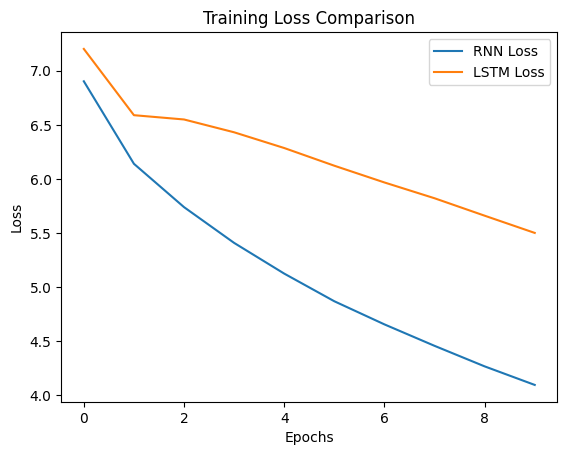

In [14]:
import matplotlib.pyplot as plt

# Train LSTM Model
lstm_loss = train_lstm(dataset, lstm_model, 4, 256, 10)

# Plot both loss curves
plt.plot(train_loss_rnn, label='RNN Loss')
plt.plot(lstm_loss, label='LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison')
plt.show()


### Task 2 (2 points)

The goal of this task is to download a multi-label text classification dataset from the [Hugging Face Hub](https://huggingface.co/datasets) and load it.

a) Select the `Text Classification` tag on the left, multi-label-classificationas as well as the the "1K<n<10K" tag to find a relatively small dataset. (e.g., sem_eval_2018_task_1 >> subtask5.english)

b) Load your dataset using `load_dataset` and check (print) the last data point in the validation set.

**Hint:** If you don't have access to GPU, you can downsample the dataset.

In [152]:
dataset = load_dataset("yelp_review_full")

dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [154]:
dataset['train'] = dataset['train'][:6000]
dataset['test'] = dataset['test'][:2000]

In [157]:
last_validation_example = dataset['test'][-1]
print("\nLast Validation Data Point:")
print(last_validation_example)


Last Validation Data Point:
{'label': 2, 'text': 'The food tasted really good, the time to make it, however, took a while.'}


### Task 3 (3 points)

a) Write a function `tokenize_data(dataset)` that takes the loaded dataset as input and returns the encoded dataset for both text and labels.


**Hints:**

1. You should tokenize the text using the BERT tokenizer `bert-base-uncased`
2. You also need to provide labels to the model as numbers. For multi-label text classification, this is a matrix of shape (batch_size, num_labels). This should be a tensor of floats rather than integers.
3. You can apply the function `tokenize_data(dataset)` to the the dataset using `map()`. (You can check out the exercise!)
4. You should set the format of the data to PyTorch tensors using `encoded_dataset.set_format("torch")`. This will turn the training, validation and test sets into standard PyTorch.

b) Print the `keys()` of the the last data point in the validation set in the encoded dataset.

**Hint:** The output should be as follows:

`dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])`

In [160]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(example):
    encoding = tokenizer(
        example['text'],
        truncation=True,
        padding='max_length',
        max_length=128
    )

    label = example['label'] - 1

    # One-hot encoding
    one_hot = [1.0 if i == label else 0.0 for i in range(5)]

    encoding['labels'] = one_hot

    return encoding


encoded_dataset = dataset.map(tokenize_data, batched=False)


encoded_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

last_validation_example = encoded_dataset['test'][-1]

# Print the keys of the last validation data point
print(last_validation_example.keys())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


### Task 4 (15 points)

Implement and compare two different approaches for text classification on a multilabel dataset. One approach will utilize BERT for tokenization and classification, while the other will use an alternative method such as (TF-IDF + SVM) or (BOW + LR).

a) **BERT Approach:**


``1.`` Define a text classification model that includes a pre-trained base ``(bert-base-uncased)`` using ``AutoModelForSequenceClassification``.

**Hints:**

       
- Create two dictionaries that map labels to integers and vice versa for the ``id2label`` and ``label2id`` parameters in  `.from_pretrained function` .
        
- Set the `problem_type` to "multi_label_classification" to ensure the appropriate loss function is used.
        
``2.`` Train the BERT-based model using HuggingFace's Trainer API.

**Hints:**
- Utilize `TrainingArguments` and `Trainer` classes.

- While training, compute metrics using a ``compute_metrics`` function that returns a dictionary with the desired metric values.

b) **Alternative Approach:**


``1.`` Choose an alternative approach for tokenization and classification. For example, use TF-IDF  or Bag of Words (BoW) for tokenization and a traditional classifier like SVM or logistic regression for classification.

**Hints:**

  - Use scikit-learn library for the  implementations.

``2.`` Train the alternative approach (model) on the same dataset you used for the BERT approach.

__Hints:__

  - Use appropriate training and evaluation procedures for the chosen alternative approach.
  
``3.`` Evaluate the performance of both models on the validation set using the metrics Accuracy, F1-score, precision, recall.

c) **Discussion:**

 Discuss the strengths and weaknesses of each approach.

__Note:__ Feel free to explore variations and improvements for both approaches. Experiment with hyperparameters and preprocessing steps to enhance the models' performance.


In [161]:
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [162]:
num_labels = 5
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create dictionaries for labels
label2id = {str(i): i for i in range(num_labels)}
id2label = {v: k for k, v in label2id.items()}

# Load BERT model for sequence classification (multi-label)
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification"
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [163]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions


    probs = torch.sigmoid(torch.tensor(preds))

    preds = (probs > 0.5).int().cpu().numpy()

    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [165]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    report_to="none",  # Disable WandB
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.325337,0.287500,0.145808,0.252627,0.103416
2,0.328600,0.325679,0.492000,0.399585,0.421595,0.392374
3,0.210100,0.356512,0.521000,0.408587,0.422955,0.397338


TrainOutput(global_step=1125, training_loss=0.25846990627712674, metrics={'train_runtime': 513.693, 'train_samples_per_second': 35.04, 'train_steps_per_second': 2.19, 'total_flos': 1184031641088000.0, 'train_loss': 0.25846990627712674, 'epoch': 3.0})

In [166]:
bert_results = trainer.evaluate()
print("BERT Model Evaluation Metrics:", bert_results)

BERT Model Evaluation Metrics: {'eval_loss': 0.3565117120742798, 'eval_accuracy': 0.521, 'eval_f1': 0.4085872439994723, 'eval_precision': 0.42295531656356394, 'eval_recall': 0.3973378533552067, 'eval_runtime': 15.3038, 'eval_samples_per_second': 130.686, 'eval_steps_per_second': 2.091, 'epoch': 3.0}


In [170]:
X_train = dataset['train']['text'][:8000]
y_train = dataset['train']['label'][:8000]
X_test = dataset['test']['text'][:2000]
y_test = dataset['test']['label'][:2000]

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(X_train)
X_val = tfidf_vectorizer.transform(X_test)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

val_predictions = lr_model.predict(X_val)


print("Evaluating models...")
bert_metrics = trainer.evaluate()
print("BERT metrics:", bert_metrics)

alternative_metrics = {
        "accuracy": accuracy_score(y_test, val_predictions),
        "f1": f1_score(y_test, val_predictions, average="weighted"),
        "precision": precision_score(y_test, val_predictions, average="weighted"),
        "recall": recall_score(y_test, val_predictions, average="weighted"),
    }
print("TF-IDF + Logistic Regression metrics:", alternative_metrics)

Evaluating models...


BERT metrics: {'eval_loss': 0.3565117120742798, 'eval_accuracy': 0.521, 'eval_f1': 0.4085872439994723, 'eval_precision': 0.42295531656356394, 'eval_recall': 0.3973378533552067, 'eval_runtime': 14.9807, 'eval_samples_per_second': 133.505, 'eval_steps_per_second': 2.136, 'epoch': 3.0}
TF-IDF + Logistic Regression metrics: {'accuracy': 0.484, 'f1': 0.48300808220151076, 'precision': 0.48554440831071893, 'recall': 0.484}


Model Architectures:

BERT: A transformer-based model pre-trained on large datasets, capturing complex relationships between words, making it ideal for intricate tasks requiring a deep understanding of context.
TF-IDF + Logistic Regression: A simpler approach using statistical text features (TF-IDF) combined with logistic regression for classification, which is faster but may miss deeper contextual meanings.
Performance:

Accuracy: BERT generally performs better, excelling in understanding context, while logistic regression is effective for simpler tasks but less accurate.
F1-Score, Precision, Recall: BERT offers better balance, whereas logistic regression may suffice for basic tasks but lacks nuanced performance.
Strengths:

BERT: High performance on complex NLP tasks and context understanding.
TF-IDF + Logistic Regression: Fast, simple, and computationally efficient, with easier interpretation.
Weaknesses:

BERT: Resource-intensive, requiring significant computational power and training time.
TF-IDF + Logistic Regression: Struggles with complex datasets, as it doesn't capture deeper meanings or context effectively.
Limitations:

BERT: Needs fine-tuning and is sensitive to hyperparameters.
TF-IDF + Logistic Regression: Limited by its reliance on word frequency and struggles with capturing context.
